In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")
from diffusion import *
import matplotlib.pyplot as plt
import numpy as np

In [33]:
T= 200

lin_bet = linear_beta_schedule(T, beta_start=0.0001, beta_end=0.02)
cos_bet = cosine_beta_schedule(T, s=0.008)
tanh_bet = tanh61_beta_schedule(T)

The SNR is defined as:
$$
SNR(t) := \frac{\bar{\alpha}}{1-\bar{\alpha}}
$$

In [13]:
# function that, given beta values, computes the SNR
# and returns the snr values and accumulated alphas
def snr(betas):
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    # compute snr
    snr = alphas_cumprod / (1. - alphas_cumprod)

    # turn into numpy array
    snr = snr.numpy()
    # plot the number of steps vs log(snr)
    # in one subplot
    # create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(np.log(snr))
    ax1.set_xlabel("Number of steps")
    ax1.set_ylabel("log(SNR)")
    ax1.set_title("log(SNR) vs number of steps")

    # plot the steps vs sqrt of alphas_cumprod
    ax2.plot(np.arange(T),np.sqrt(alphas_cumprod))
    ax2.set_xlabel("Number of steps")
    ax2.set_ylabel(r"$\sqrt{\bar{\alpha}}$")
    ax2.set_title(r"$\sqrt{\bar{\alpha}}$ vs number of steps")
    
    # set a separation between the two plots
    fig.tight_layout(pad=1.0)
    plt.show()
    return snr, alphas_cumprod.numpy()
    
    


### Linear schedule

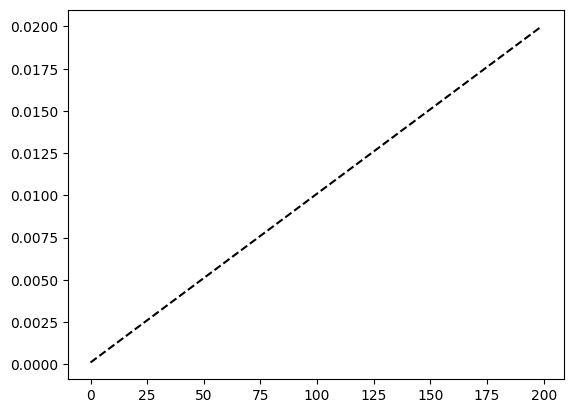

In [34]:
# plot a line
plt.plot(np.arange(T), lin_bet, linestyle='--', color='k', label='Linear schedule')

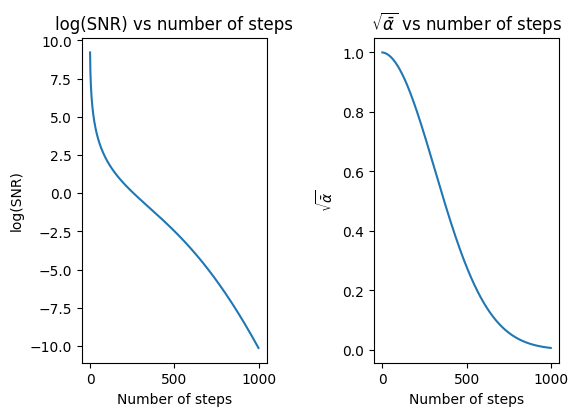

In [79]:
lin_snr, lin_alphbar = snr(lin_bet)

In [80]:
# get the snr value at the last step
print("SNR at last step for linear schedule:", lin_snr[-1])
# get the sqrt alpha_bar value at the last step
print(r"$\sqrt{\bar{\alpha}}$ :", np.sqrt(lin_alphbar[-1]))

SNR at last step for linear schedule: 4.0359933e-05
$\sqrt{\bar{\alpha}}$ : 0.0063528186


Recall that $$ x_t = \sqrt{\bar{\alpha_t}}x_{0} + \sqrt{1-\alpha_t}\epsilon $$
We can see that the SNR value achieved at the end of the schedule is not zero. Also, the accumulated alpha value is not zero, which means that the final sample, after beign diffused T times, will not be exactly pure noise but there will be a leakage from the original sample, $x_0$

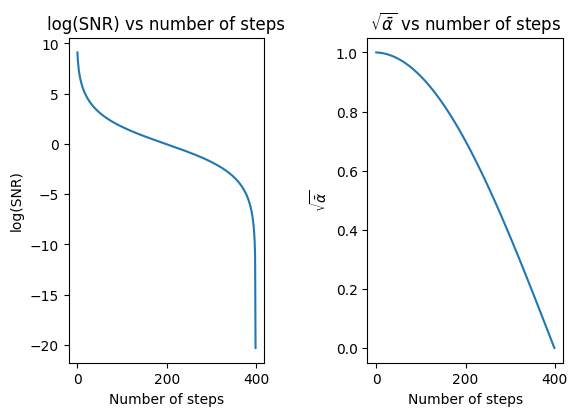

In [76]:
cos_snr, cos_alphbar = snr(cos_bet)

In [14]:
tanh_snr, tanh_alphbar = snr(tanh_bet)

In [15]:
tanh_alphbar[-5:]**0.5

array([0.0925699 , 0.07990224, 0.06502347, 0.04582584, 0.00144913],
      dtype=float32)

Test for fast sampling schedule

In [98]:
T=200
#training_noise_schedule = linear_beta_schedule(T, beta_start=0.0001, beta_end=0.05)
training_noise_schedule = np.linspace(1e-4, 0.05, 50)
#training_noise_schedule = tanh61_beta_schedule(T).numpy()
talpha = 1 - training_noise_schedule
talpha_cum = np.cumprod(talpha)

inference_noise_schedule = np.array([0.0001, 0.001, 0.01, 0.05, 0.2, 0.5]) 
beta = inference_noise_schedule
alpha = 1 - beta
alpha_cum = np.cumprod(alpha)
    
# this is only relevant if we use the fast sampling procedure
ts = []
# compute the aligned diffusion steps for sampling
for s in range(len(inference_noise_schedule)):
    for t in range(len(training_noise_schedule) - 1):
        # eq 14 of the DiffWave paper, appendix B
        if talpha_cum[t+1] <= alpha_cum[s] <= talpha_cum[t]:
            print(s)
            ts_aligned = (talpha_cum[t]**0.5 - alpha_cum[s]**0.5) / (talpha_cum[t]**0.5 - talpha_cum[t+1]**0.5)
            ts_aligned = ts_aligned + t
            ts.append(ts_aligned)
            break

ts = np.array(ts, dtype=np.float32)   
        

0
1
2
3
4
5


In [99]:
training_noise_schedule

array([0.0001    , 0.00111837, 0.00213673, 0.0031551 , 0.00417347,
       0.00519184, 0.0062102 , 0.00722857, 0.00824694, 0.00926531,
       0.01028367, 0.01130204, 0.01232041, 0.01333878, 0.01435714,
       0.01537551, 0.01639388, 0.01741224, 0.01843061, 0.01944898,
       0.02046735, 0.02148571, 0.02250408, 0.02352245, 0.02454082,
       0.02555918, 0.02657755, 0.02759592, 0.02861429, 0.02963265,
       0.03065102, 0.03166939, 0.03268776, 0.03370612, 0.03472449,
       0.03574286, 0.03676122, 0.03777959, 0.03879796, 0.03981633,
       0.04083469, 0.04185306, 0.04287143, 0.0438898 , 0.04490816,
       0.04592653, 0.0469449 , 0.04796327, 0.04898163, 0.05      ])

In [100]:
beta

array([1.e-04, 1.e-03, 1.e-02, 5.e-02, 2.e-01, 5.e-01])

In [102]:
alpha_cum

array([0.9999    , 0.9989001 , 0.9889111 , 0.93946554, 0.75157244,
       0.37578622])

In [103]:
talpha_cum.max(), talpha_cum.min()

(0.9999, 0.27967250019288403)

In [15]:
talpha_cum

tensor([1.0000e+00, 9.9999e-01, 9.9999e-01, 9.9999e-01, 9.9998e-01, 9.9997e-01,
        9.9996e-01, 9.9994e-01, 9.9992e-01, 9.9989e-01, 9.9986e-01, 9.9981e-01,
        9.9974e-01, 9.9966e-01, 9.9954e-01, 9.9939e-01, 9.9919e-01, 9.9893e-01,
        9.9858e-01, 9.9812e-01, 9.9752e-01, 9.9671e-01, 9.9565e-01, 9.9425e-01,
        9.9241e-01, 9.8997e-01, 9.8677e-01, 9.8256e-01, 9.7704e-01, 9.6981e-01,
        9.6039e-01, 9.4818e-01, 9.3243e-01, 9.1228e-01, 8.8676e-01, 8.5484e-01,
        8.1555e-01, 7.6812e-01, 7.1219e-01, 6.4802e-01, 5.7669e-01, 5.0013e-01,
        4.2098e-01, 3.4228e-01, 2.6697e-01, 1.9752e-01, 1.3563e-01, 8.2133e-02,
        3.7090e-02, 3.7089e-05])

In [28]:
talpha_cum[-1] <= alpha_cum[-1] <= talpha_cum[-2]

False

we have to choose the betas for the fast sampling process wrt the noise schedule we use.  
in diffwave, they used {0.0001, 0.001, 0.01, 0.05, 0.2, 0.5} for a training schedule that is linear: beta in [1e-4, 0.02], which is weird because as we can see, the training schedule has a max value of 0.02, which is far below the 0.5 used for fast sampling.  
If we check the equivalent
In diffwave, they found that the most effective denoising steps occured near $x_0$. Therefore, we can choose our sampling schedule with the betas value that are the closer to the last diffusion steps.

In [82]:
T=200
training_noise_schedule = tanh61_beta_schedule(T).numpy()
talpha = 1 - training_noise_schedule
talpha_cum = np.cumprod(talpha)
training_noise_schedule[-5:]  
        

array([0.2204405, 0.269327 , 0.3506385, 0.5130584, 0.999    ],
      dtype=float32)

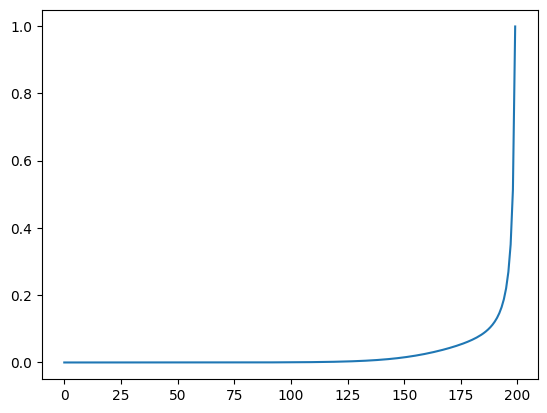

In [48]:
plt.plot(np.arange(0, T), training_noise_schedule)

In [83]:
training_noise_schedule[:10]

array([5.0579541e-07, 5.4246948e-07, 5.8180268e-07, 6.2398783e-07,
       6.6923172e-07, 7.1775611e-07, 7.6979882e-07, 8.2561502e-07,
       8.8547824e-07, 9.4968198e-07], dtype=float32)

In [93]:
inference_noise_schedule = np.array([1e-07,1e-4, 0.001, 0.2, 0.3, 0.5, 0.99]) 
# set to numpy float 32
inference_noise_schedule = inference_noise_schedule.astype(np.float32)
beta = inference_noise_schedule
alpha = 1 - beta
alpha_cum = np.cumprod(alpha)
    
# this is only relevant if we use the fast sampling procedure
ts = []
# compute the aligned diffusion steps for sampling
for s in range(len(inference_noise_schedule)):
    for t in range(len(training_noise_schedule) - 1):
        # eq 14 of the DiffWave paper, appendix B
        if talpha_cum[t+1] <= alpha_cum[s] <= talpha_cum[t]:
            ts_aligned = (talpha_cum[t]**0.5 - alpha_cum[s]**0.5) / (talpha_cum[t]**0.5 - talpha_cum[t+1]**0.5)
            ts_aligned = ts_aligned + t
            ts.append(ts_aligned)
            break

ts = np.array(ts, dtype=np.float32) 

In [94]:
ts

array([ 38.03846 ,  71.387314, 148.4617  , 163.92284 , 178.30339 ,
       198.44269 ], dtype=float32)

In [59]:
alpha_cum

array([0.9999999 , 0.9998999 , 0.9989    , 0.79912   , 0.559384  ,
       0.279692  , 0.00279692])

In [79]:
talpha_cum[178], talpha_cum[179]

(0.28532752, 0.2669654)

In [80]:
t = 178
talpha_cum[t+1] <= alpha_cum[-2] <= talpha_cum[t]

True

In [55]:
talpha_cum

array([9.9999952e-01, 9.9999899e-01, 9.9999839e-01, 9.9999779e-01,
       9.9999714e-01, 9.9999642e-01, 9.9999565e-01, 9.9999481e-01,
       9.9999392e-01, 9.9999297e-01, 9.9999195e-01, 9.9999088e-01,
       9.9998969e-01, 9.9998844e-01, 9.9998707e-01, 9.9998564e-01,
       9.9998409e-01, 9.9998242e-01, 9.9998063e-01, 9.9997872e-01,
       9.9997669e-01, 9.9997449e-01, 9.9997211e-01, 9.9996960e-01,
       9.9996686e-01, 9.9996394e-01, 9.9996084e-01, 9.9995750e-01,
       9.9995393e-01, 9.9995005e-01, 9.9994594e-01, 9.9994153e-01,
       9.9993676e-01, 9.9993169e-01, 9.9992621e-01, 9.9992037e-01,
       9.9991411e-01, 9.9990737e-01, 9.9990016e-01, 9.9989241e-01,
       9.9988407e-01, 9.9987513e-01, 9.9986553e-01, 9.9985528e-01,
       9.9984425e-01, 9.9983245e-01, 9.9981982e-01, 9.9980623e-01,
       9.9979168e-01, 9.9977607e-01, 9.9975932e-01, 9.9974138e-01,
       9.9972212e-01, 9.9970144e-01, 9.9967927e-01, 9.9965549e-01,
       9.9962997e-01, 9.9960262e-01, 9.9957329e-01, 9.9954188e